*Adapted from Haghighi et al. 2022*

Be sure to have *utils* folder in the working directory

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import keras
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from utils.readProfiles import *
from utils.pred_models import *
import os

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
# import umap

##### create single blue colormap to change defualt colors in yellowbrick
from matplotlib.colors import ListedColormap
blue_cmap = cm.get_cmap('Blues', 200)
single_blue_cmap=ListedColormap(blue_cmap(np.linspace(0.7, 0.9, 20)))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_4114396/4144160005.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blue_cmap = cm.get_cmap('Blues', 200)


In [14]:
input_folder = "../zenodoArchive"
out_folder = "out3.2"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Cross validation from multi meta cells per exp pop

In [15]:
cpMulti = pd.read_csv(f"{input_folder}/CPGEX_cpMetacellsPerCellLine.tsv", sep="\t", index_col=0)
gexMulti= pd.read_csv(f"{input_folder}/CPGEX_gexMetacellsPerCellLine.tsv", sep="\t", index_col=0)

samples = np.intersect1d(cpMulti.index,gexMulti.index)

cpMulti = cpMulti.loc[samples,:]
gexMulti = gexMulti.loc[samples,:]



In [ ]:
cp_features = np.array(cpMulti.columns)
gex_features = np.array(gexMulti.columns)

sampleAnnot = pd.DataFrame(index=samples,columns=["expPop","cellLine","day","metaCell"])
for i in range(len(samples)):
    sampleAnnot.loc[samples[i],"expPop"] = samples[i][0:8]
    sampleAnnot.loc[samples[i],"cellLine"] = samples[i][4:8]
    sampleAnnot.loc[samples[i],"day"] = int(samples[i][1:3])
    sampleAnnot.loc[samples[i],"metaCell"] = samples[i][9:12]



In [17]:
#metaCell is in m1 or m2

trainingSamples = sampleAnnot[sampleAnnot["metaCell"].isin(["m1","m2"])].index
testSamples = sampleAnnot[sampleAnnot["metaCell"].isin(["m3"])].index

cpTrain = cpMulti.loc[trainingSamples,:]
gexTrain = gexMulti.loc[trainingSamples,:]

cpTest = cpMulti.loc[testSamples,:]
gexTest = gexMulti.loc[testSamples,:]

In [ ]:
#train model cp2gex
cp2GexModels = pd.DataFrame(index=np.concatenate((np.array(["intercept"]),cp_features)),columns=gex_features)

for g in gex_features:
    model = linear_model.Lasso(alpha=0.02, max_iter = 10000)
    model.fit(cpTrain,gexTrain[g])
    coef=model.coef_
    intercept=model.intercept_
    cp2GexModels.loc[:,g]=np.concatenate((np.array([intercept]),coef),axis=0)

cp2GexModels.to_csv(f"./{out_folder}/CPGEX_CPmodellLasso", sep='\t',index=True,header=True)

/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.478e-05, tolerance: 2.468e-05
  model = cd_fast.enet_coordinate_descent(
/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.110e-04, tolerance: 5.074e-05
  model = cd_fast.enet_coordinate_descent(
/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

In [ ]:
#validation
gexPred = pd.DataFrame(index=gexTest.index,columns=gexTest.columns)
for g in gexTest.columns:
    gexPred.loc[:,g] = cp2GexModels.loc["intercept",g] + np.dot(cpTest,cp2GexModels.loc[cp_features,g])
    

In [46]:
#evaluate model performance

#compute correlation between predicted and observed samples
gexPredCorr = np.array([0.0]*len(gexTest.index))
for i in range(len(gexTest.index)):
    np.corrcoef(
        gexPred.loc[gexTest.index[i], :].values.astype(float),
        gexTest.loc[gexTest.index[i], :].values.astype(float)
    )

#plot gene to gene value for each sample
for i in range(len(gexTest.index)):
    plt.scatter(gexPred.loc[gexTest.index[i],:],gexTest.loc[gexTest.index[i],:])
    plt.xlabel("predicted")
    plt.ylabel("observed")
    plt.title(gexTest.index[i])
    plt.savefig(f"./{out_folder}/gexPredObserved"+gexTest.index[i]+".png")
    plt.close()

In [49]:
#train model gex2cp
gex2cpModels = pd.DataFrame(index=np.concatenate((np.array(["intercept"]),gex_features)),columns=cp_features)

for c in cp_features:
    model = linear_model.Lasso(alpha=0.02, max_iter = 10000)
    model.fit(gexTrain,cpTrain[c])
    coef=model.coef_
    intercept=model.intercept_
    gex2cpModels.loc[:,c]=np.concatenate((np.array([intercept]),coef),axis=0)

gex2cpModels.to_csv(f"./{out_folder}/CPGEX_GeXmodellLasso.tsv",    sep='\t',index=True,header=True)

/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.449e+01, tolerance: 1.821e+01
  model = cd_fast.enet_coordinate_descent(
/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.645e+01, tolerance: 4.107e+01
  model = cd_fast.enet_coordinate_descent(
/home/drum/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

In [50]:
#validation
cpPred = pd.DataFrame(index=cpTest.index,columns=cpTest.columns)
for c in cpTest.columns:
    cpPred.loc[:,c] = gex2cpModels.loc["intercept",c] + np.dot(gexTest,gex2cpModels.loc[gex_features,c])
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/dmeister/OneDriveUniv/KilpinenPostdoc/tryCPcode/Code/CellPainting_GeneEXpression/out3.2/plot/cpPredObservedd20_11.4.m3.png'

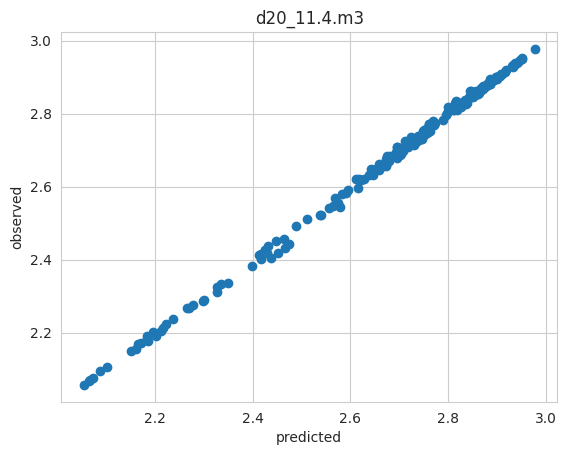

In [ ]:
#evaluate model performance

#compute correlation between predicted and observed samples
cpPredCorr = np.array([0.0]*len(cpTest.index))
for i in range(len(cpTest.index)):
    corr_matrix = np.corrcoef(
        cpPred.loc[cpTest.index[i], :].values.astype(float),
        cpTest.loc[cpTest.index[i], :].values.astype(float)
    )
    cpPredCorr[i] = corr_matrix[0, 1]

#plot gene to gene value for each sample
for i in range(len(cpTest.index)):
    # plot on log10 scale, add small constant to avoid log10(0)
    pred_vals = cpPred.loc[cpTest.index[i], :].values.astype(float)
    obs_vals = cpTest.loc[cpTest.index[i], :].values.astype(float)
    epsilon = 1e-8
    plt.scatter(np.log10(pred_vals + epsilon), np.log10(obs_vals + epsilon))
    plt.xlabel("predicted")
    plt.ylabel("observed")
    plt.title(cpTest.index[i])
    plt.savefig(f"./{out_folder}/cpPredObserved" + cpTest.index[i] + ".png")
    plt.close()

In [ ]:

cpPred.to_csv(f"./{out_folder}/cpPred.tsv",    sep='\t',index=True,header=True)
cpTest.to_csv(f"./{out_folder}/cpTest.tsv",    sep='\t',index=True,header=True)
gexPred.to_csv(f"./{out_folder}/gexPred.tsv",    sep='\t',index=True,header=True)
gexTest.to_csv(f"./{out_folder}/gexTest.tsv",    sep='\t',index=True,header=True)

# Linear Regression for performing GSEA

In [ ]:
#same with linear model without regularization
cp2GexModelsLinear = pd.DataFrame(index=np.concatenate((np.array(["intercept"]),cp_features)),columns=gex_features)

for g in gex_features:
    model = linear_model.LinearRegression()
    model.fit(cpTrain,gexTrain[g])
    coef=model.coef_
    intercept=model.intercept_
    cp2GexModelsLinear.loc[:,g]=np.concatenate((np.array([intercept]),coef),axis=0)

cp2GexModelsLinear.to_csv(f"./{out_folder}/CPGEX_CPmodelLinear.tsv", sep='\t',index=True,header=True)

In [ ]:
gex2cpModelsLinear = pd.DataFrame(index=np.concatenate((np.array(["intercept"]),gex_features)),columns=cp_features)

for c in cp_features:
    model = linear_model.LinearRegression()
    model.fit(gexTrain[gex_features],cpTrain[c])
    coef=model.coef_
    intercept=model.intercept_
    gex2cpModelsLinear.loc[:,c]=np.concatenate((np.array([intercept]),coef),axis=0)

gex2cpModelsLinear.to_csv(f"./{out_folder}/CPGEX_GeXmodelLinear.tsv",    sep='\t',index=True,header=True)